# Lecture 3, Data science in Neuroscience


## Plan for today

1. Writing functions
2. Review of last week's exercises
3. Saving your functions as a python module
4. Detecting action potentials and spike clustering
    * Filtering (done)
    * Detecting spikes (done)
    * Extracting spike waveforms
    * Dimensionality reduction
    * Clustering spike waveforms

***

As always, we start by importing the functions or module that we will be using.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
from scipy.signal import sosfreqz
from scipy.signal import sosfiltfilt
from scipy.signal import find_peaks

We reload the data

In [3]:
fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

## Writing functions

Last week we develop our code line-by-line to process the data. We made sure all steps worked as expected by plotting the data.

We did not write many functions. This makes it harder to re-run this same code.

### Why using functions is a good idea?

1. Organize your code in a clear way (one function per significant step)
2. Make it easy to re-run your code (one line call to a function executes many hidden lines of code)
3. The functions can be defined in a module and loaded with 1 line of code.
4. Avoid having several copies of your code. If there is a bug in the code, it is better if there is only one copy of it!


### Steps to write functions (the easy way)

1. Don't start with a function. Start by running your analysis line-by-line (like last week)
2. Test that your code is working.
3. Put the working code into a function.
4. Always document your function (what are the inputs, what does the function do, what aer the outputs)


### Debugging function

If a function is not working as expected (bug?), you need to investigate what it does in more details. 

It is sometimes easier to run the code of the function line by line in a jupyter notebook and plot the results at each step if possible.

**Divide and conquer**: Break your problem into small components that you can test individually. Repeat this strategy until you find the bug!


### 3 functions from last week

In [4]:
def plot_recording_data(dat, offset=3000, startSample=0, endSample=5000):
    """
    Function to plot our electrophysiology data
    
    Arguments
    dat: 2D numpy array containing in-vivo recordings. The dimensions are : [channel,sample]
    offset: offset between each channel to avoid plotting all channels on top of each other
    startSample: first sample to show
    endSample: last sample to show
    """
    
    plt.figure(figsize=(20,10)) # set the size of the figure
    for i in range(dat.shape[0]): #loop for every channel
        plt.plot(dat[i,startSample:endSample]-i*offset,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
    plt.legend()
    plt.show()
    
def create_butter_highpass_filter(lowcut, fs, order=3):
    """
    Create a highpass Butterworth filter using scipy.signal.butter()
    
    Arguments:
    lowcut: low cut frequency 
    fs: sampling rate
    order: order of the filter
    
    Return:
    The function returns a filter in the sos format
    """
    nyq = 0.5 * fs # Nyquist frequency (sampling rate/2)
    low = lowcut / nyq # lowcut as a proportion of Nyquist frequency
    sos = butter(order, [low], btype='highpass' ,  output='sos') #‘sos’ should be used for general-purpose filtering.
    return sos


def filter_raw_data(dat,lowcut=300, fs=20000):
    """
    Function to filter the raw data by applying a highpass filter
    
    Arguments:
    dat: 2D numpy array containing raw in-vivo recordings. The dimensions are : [channel,sample]
    lowcut: low cut frequency 
    fs: sampling rate
    order: order of the filter
    
    Return:
    Filtered data as a 2D numpy array
    """
    # filter the data
    myFilter = create_butter_highpass_filter(lowcut = lowcut,fs=fs, order=3)
    y = sosfiltfilt(myFilter, dat) # the sosfilt() function can take a 2D array and will filter every row separately
    return y


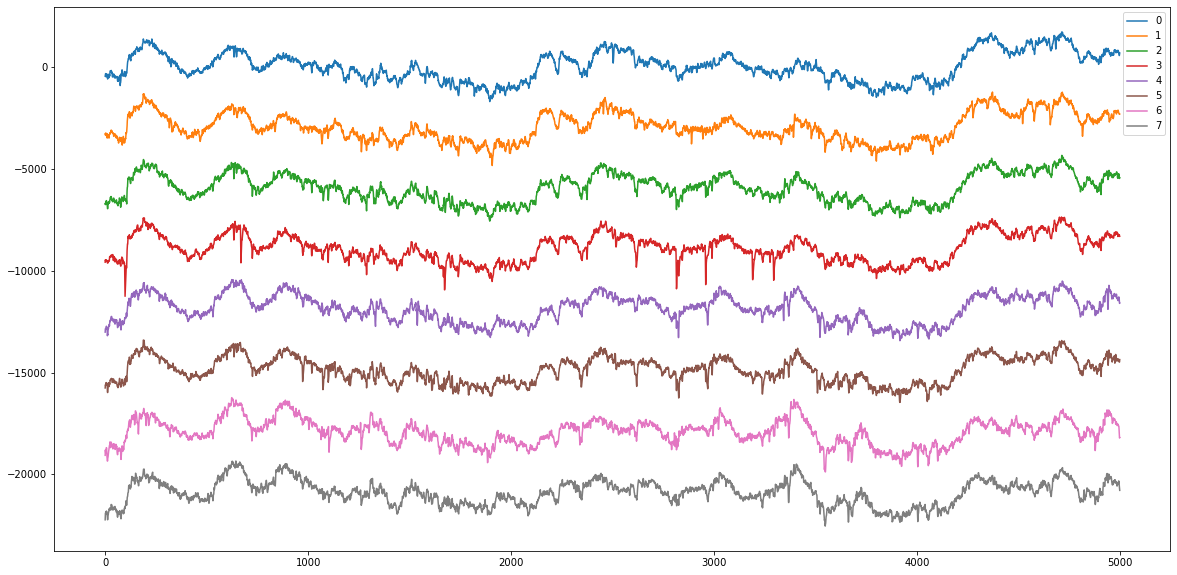

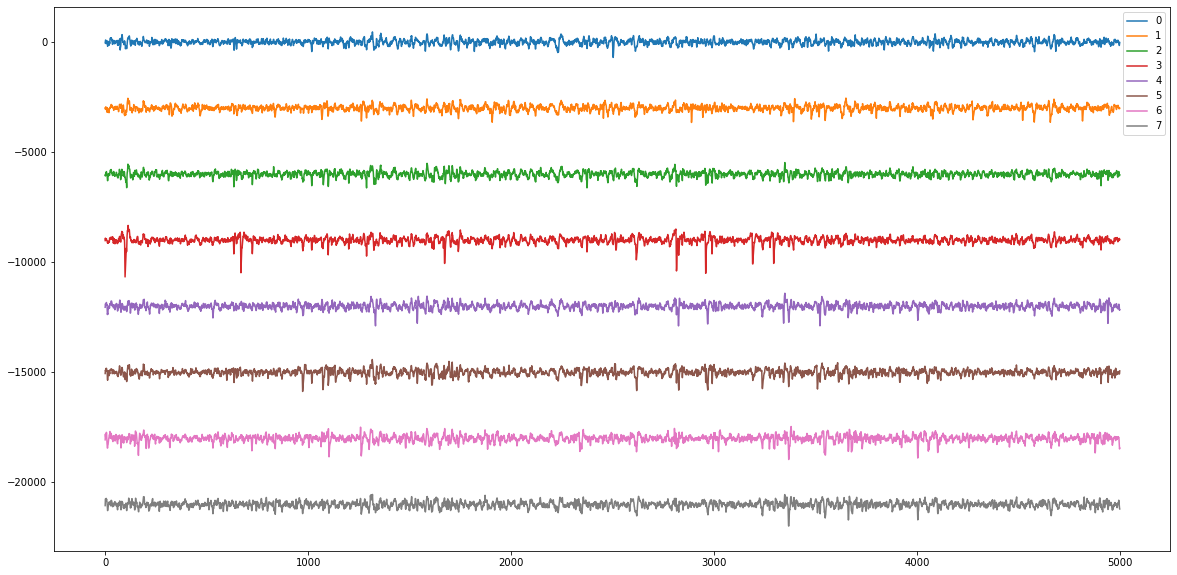

In [5]:
fs = 20000 # sampling rate
lowcut=300

plot_recording_data(dat) # plot raw data
y = filter_raw_data(dat,lowcut = lowcut, fs=fs)  # filter the data
plot_recording_data(y) # plot the filtered data

### Review of last weeks' exercises

1. Write the code that would apply our spike detection procedure to the 8 recording channels in our data? 
    * You could try to use a `for` loops to loop across the channels. Within this loop, you can reuse the code that we used above.
    * You could store the spike times array in a list of array.
    
   
2. Try to plot the data from all channels with their threshold and detected spikes. This would confirm that your spike detection worked.


In [6]:
z=5 # we want spikes to be at least 5 standard deviation from the mean

# We can use Numpy mean, std to calculate the mean of each channel without a for loop
means=y.mean(axis=1)
stds=y.std(axis=1)
thresholds = means-stds*z

# We need to copy our filtered data 
yDetect = y.copy() # use a copy of the data to avoid destroying it during the manipulation

# Inverse the polarity of the signal, spikes are going up
yDetect = 0 - yDetect

# Create an empty list to store the spikes detected on each channel
spikeTimesList = [] 

# loop to detect the spikes on each channel
for i in range(dat.shape[0]):
    spikeTimes, _ = find_peaks(x=yDetect[i,:],height=0-thresholds[i]) # the function returs 2 values, we want the first one
    spikeTimesList.append(spikeTimes)
    print("Detection chan {}, {} spikes".format(i,spikeTimes.shape[0]))

Detection chan 0, 5 spikes
Detection chan 1, 17 spikes
Detection chan 2, 12 spikes
Detection chan 3, 23 spikes
Detection chan 4, 28 spikes
Detection chan 5, 22 spikes
Detection chan 6, 17 spikes
Detection chan 7, 7 spikes


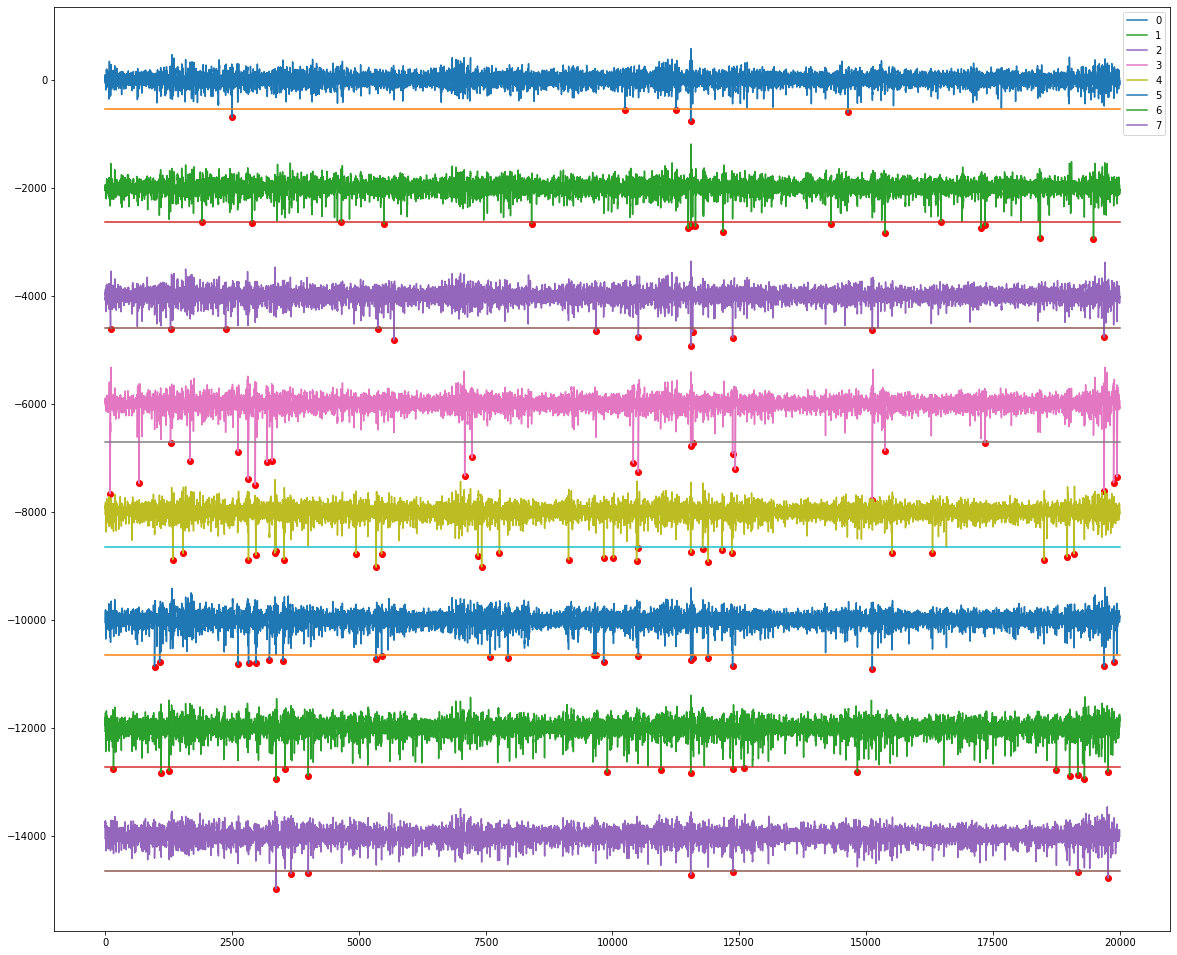

In [13]:
offset=2000
plt.figure(figsize=(20,17)) # set the size of the figure

for i in range(y.shape[0]): #loop for every channel
    plt.plot(y[i,:]-i*offset,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
    plt.plot([0,y.shape[1]],[thresholds[i]-i*offset,thresholds[i]-i*offset]) # plot the threshold
    plt.scatter(spikeTimesList[i],y[i,spikeTimesList[i]]-i*offset,c="red") # plot the spikes
plt.legend()
fn="/home/kevin/repo/dataNeuroMaster/images/spike_detection.png"
plt.savefig(fn)
plt.show()

We can organize this code as 2 functions. 

In [7]:
def spike_detection(y,z=5):
    """
    Function to perform spike detection on filtered in-vivo recordings from the brain. It gets you the time at which spikes were detected on each channel
    
    
    Arguments:
    y: 2D numpy array containing filtered in-vivo recordings. The dimensions are : [channel,sample]
    z: threshold in standard deviations from the mean for spike detection
    
    
    Returns:
    spikeTimes: List of numpy arrays containing the times of spikes detected on each channel. 
    """
    z=5 # we want spikes to be at least 5 standard deviation from the mean

    # We can use Numpy mean, std to calculate the mean of each channel without a for loop
    means=y.mean(axis=1)
    stds=y.std(axis=1)
    thresholds = means-stds*z

    # We need to copy our filtered data 
    yDetect = y.copy() # use a copy of the data to avoid destroying it during the manipulation

    # Inverse the polarity of the signal
    yDetect = 0 - yDetect

    # Create an empty list to store the spikes detected on each channel
    spikeTimesList = [] 

    # loop to detect the spikes on each channel
    for i in range(y.shape[0]):
        spikeTimes, _ = find_peaks(x=yDetect[i,:],height=0-thresholds[i]) # the function returs 2 values, we want the first one
        spikeTimesList.append(spikeTimes)
        print("Detection chan {}, {} spikes".format(i,spikeTimes.shape[0]))
    
    return spikeTimesList,thresholds

def plot_spike_detection(y,spikeTimesList,thresholds,offset=3000):
    """
    Function to plot the results of our spike detection procedure
    
    Arguments:
    y: 2D numpy array containing the filtered data
    spikeTimeList: list of 1D numpy arrays. each array contains the times of the spikes detected on one channel
    threholds: 1D numpy array containing the detection thresholds for each channel
    offset: y offset for plotting the data of each channel. To avoid plotting data on top of each other
    """
    
    plt.figure(figsize=(20,20)) # set the size of the figure
    for i in range(y.shape[0]): #loop for every channel
        plt.plot(y[i,:]-i*offset,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
        plt.plot([0,y.shape[1]],[thresholds[i]-i*offset,thresholds[i]-i*offset]) # plot the threshold
        plt.scatter(spikeTimesList[i],y[i,spikeTimesList[i]]-i*offset,c="red") # plot the spikes
    plt.legend()
    plt.show()

## Create a spikeDetection module for our function

Once your functions are tested, you can define them in a separate `.py` file and import them as a python module. 

More [information on modules](https://docs.python.org/3/tutorial/modules.html)

For instance, we can put our 5 functions in a file called `spikeDetection.py` located in the same directory as this notebook. The file needs to end with `.py`

We can run the file to define our function as follows.

Modules are essential when we work with larger projects. You don't want to have to define the functions all the time!

Here is how to use our `spikeDetection` module. See how quickly we can re-run all our analysis.

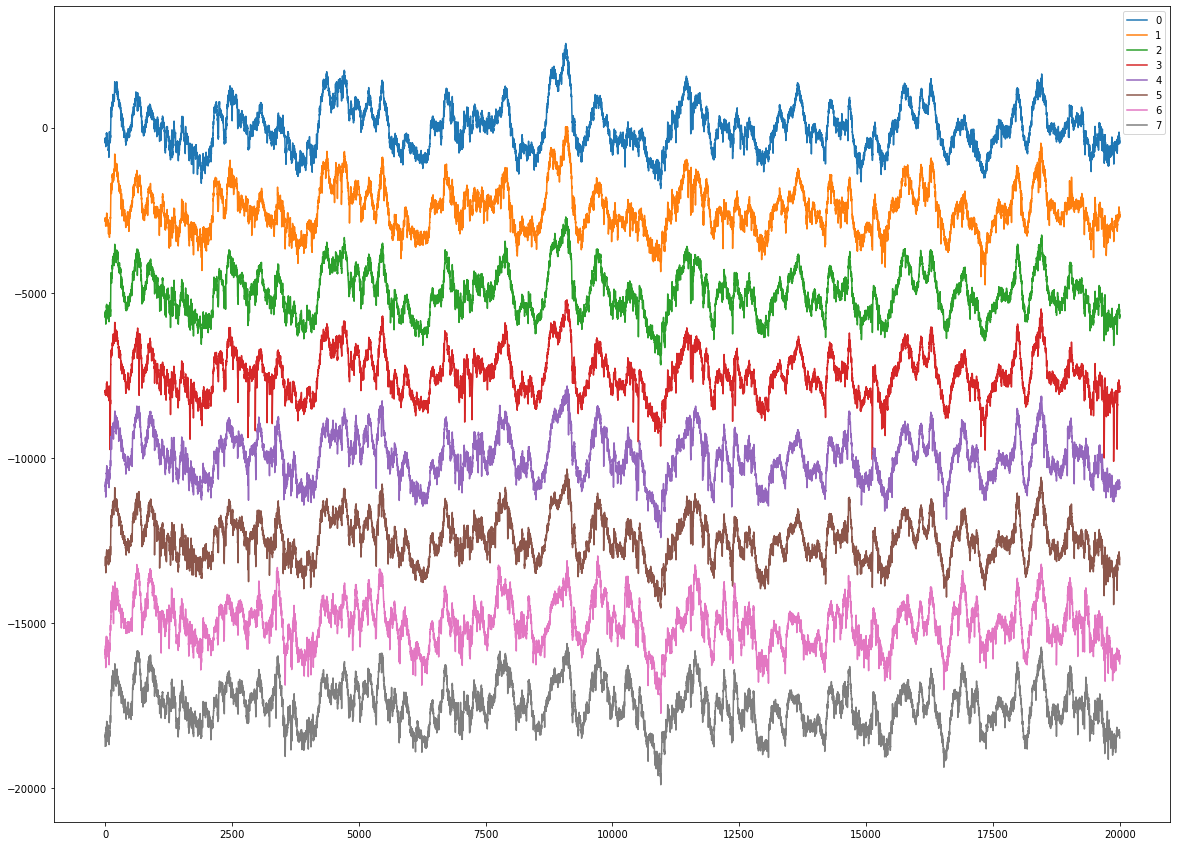

Detection chan 0, 5 spikes
Detection chan 1, 17 spikes
Detection chan 2, 12 spikes
Detection chan 3, 23 spikes
Detection chan 4, 28 spikes
Detection chan 5, 22 spikes
Detection chan 6, 17 spikes
Detection chan 7, 7 spikes


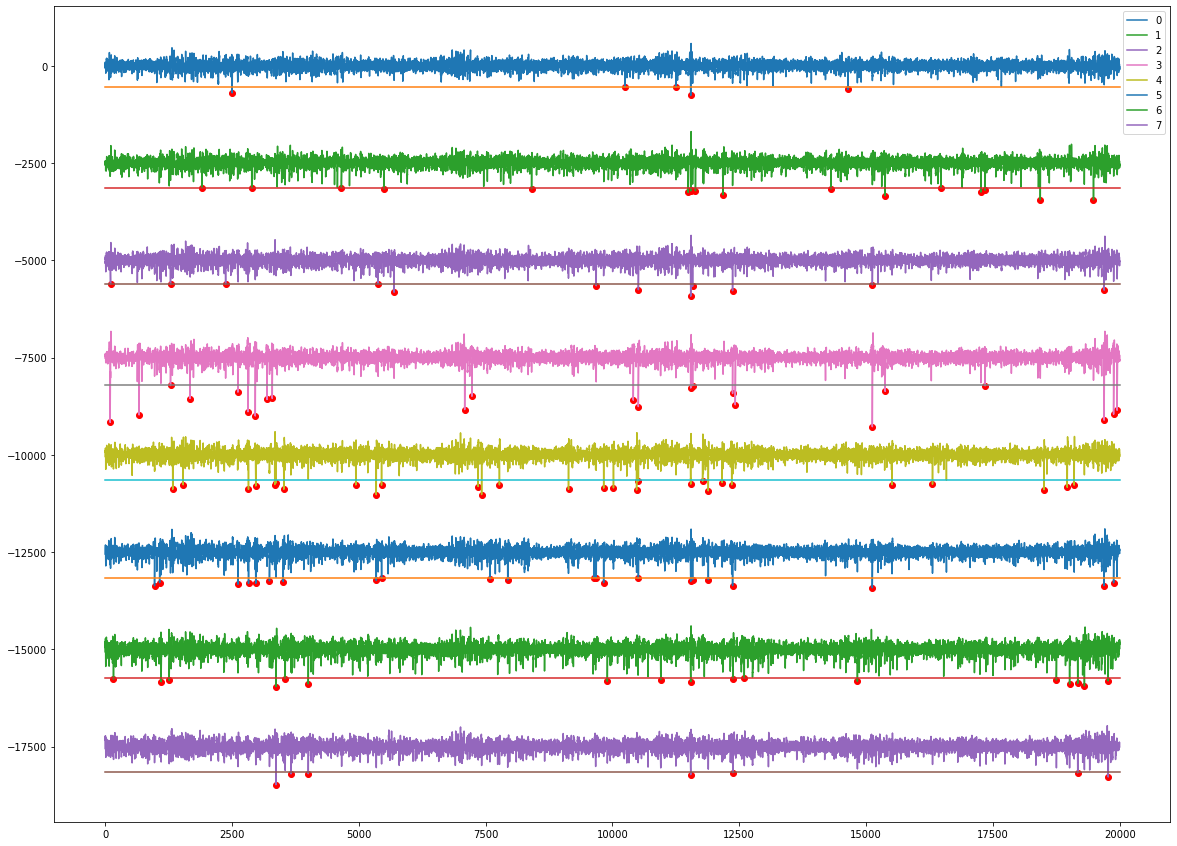

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikeDetection
# alternatively: from spikeDetection import plot_recording_data, filter_raw_data, spike_detection, plot_spike_detection
# with from ... import ... you call the function without the module name: plot_spike_detection() and not spikeDetection.plot_spike_datection()

# variables for spike detection
fs = 20000 # sampling rate
lowcut=300
z=5
offset=2500

# load the data
fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

# plot the data and run all the analysis performed so far
spikeDetection.plot_recording_data(dat,startSample=0,endSample=20000,offset=offset)
y = spikeDetection.filter_raw_data(dat,lowcut = lowcut, fs=fs)  # filter the data
spikeTimesList, thresholds = spikeDetection.spike_detection(y,z=z) # detect the spikes


spikeDetection.plot_spike_detection(y,spikeTimesList,thresholds,offset)

***
## Extracting spike waveforms


### We need more than 1 second of data

For the next steps, we will need a longer recording duration so that we have more spikes to work with. We want to make sure that most neurons have the opportunity to fire a many spikes. This will make the clustering steps easier.

The file is in the `dataNeuroMaster/data/` folder.

https://github.com/kevin-allen/dataNeuroMaster/blob/main/data/longRaw.npy


You can load a new data file containing more samples.

In [9]:
# load the data
fs=20000
fileName = "../data/longRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)
print(dat.shape,"seconds:",dat.shape[1]/fs)

(8, 1200000) seconds: 60.0


We have more than a million samples

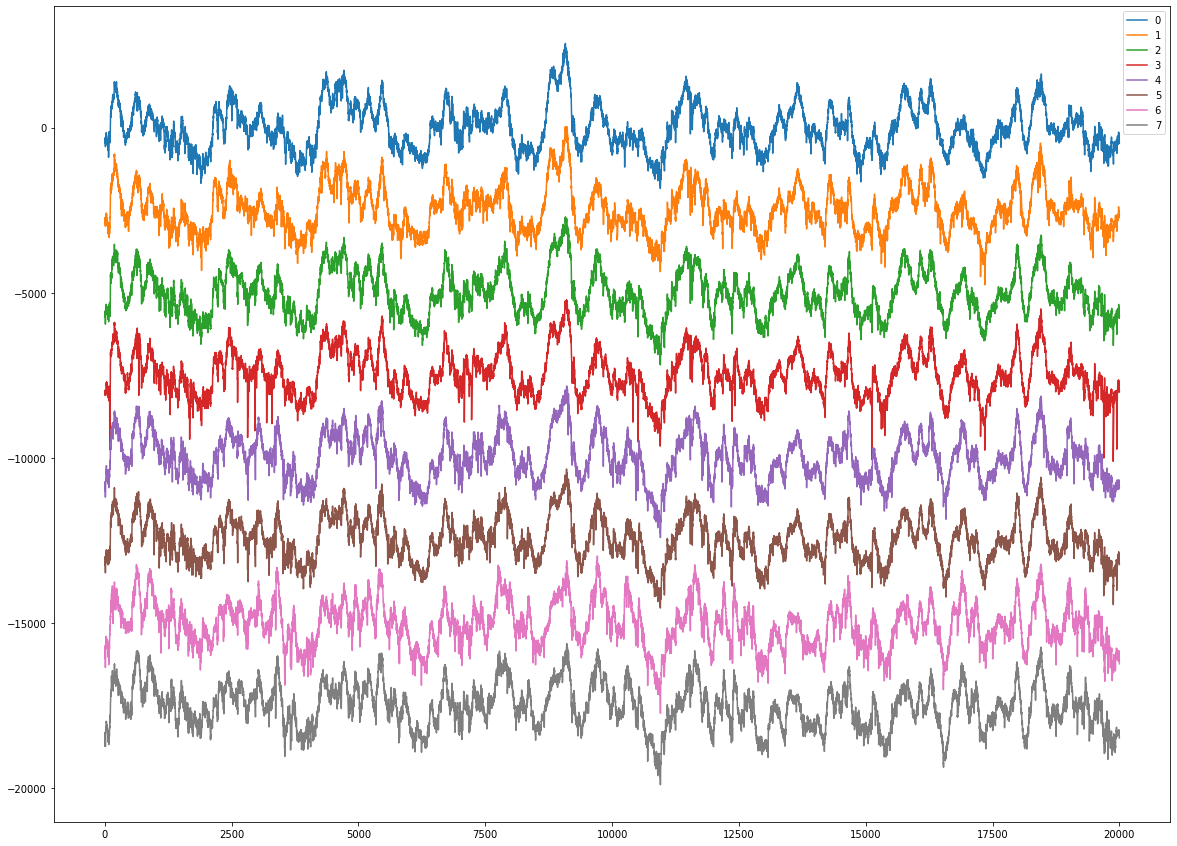

Detection chan 0, 123 spikes
Detection chan 1, 363 spikes
Detection chan 2, 134 spikes
Detection chan 3, 656 spikes
Detection chan 4, 612 spikes
Detection chan 5, 256 spikes
Detection chan 6, 224 spikes
Detection chan 7, 278 spikes


/home/kevin/anaconda3/envs/DLC-GPU/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


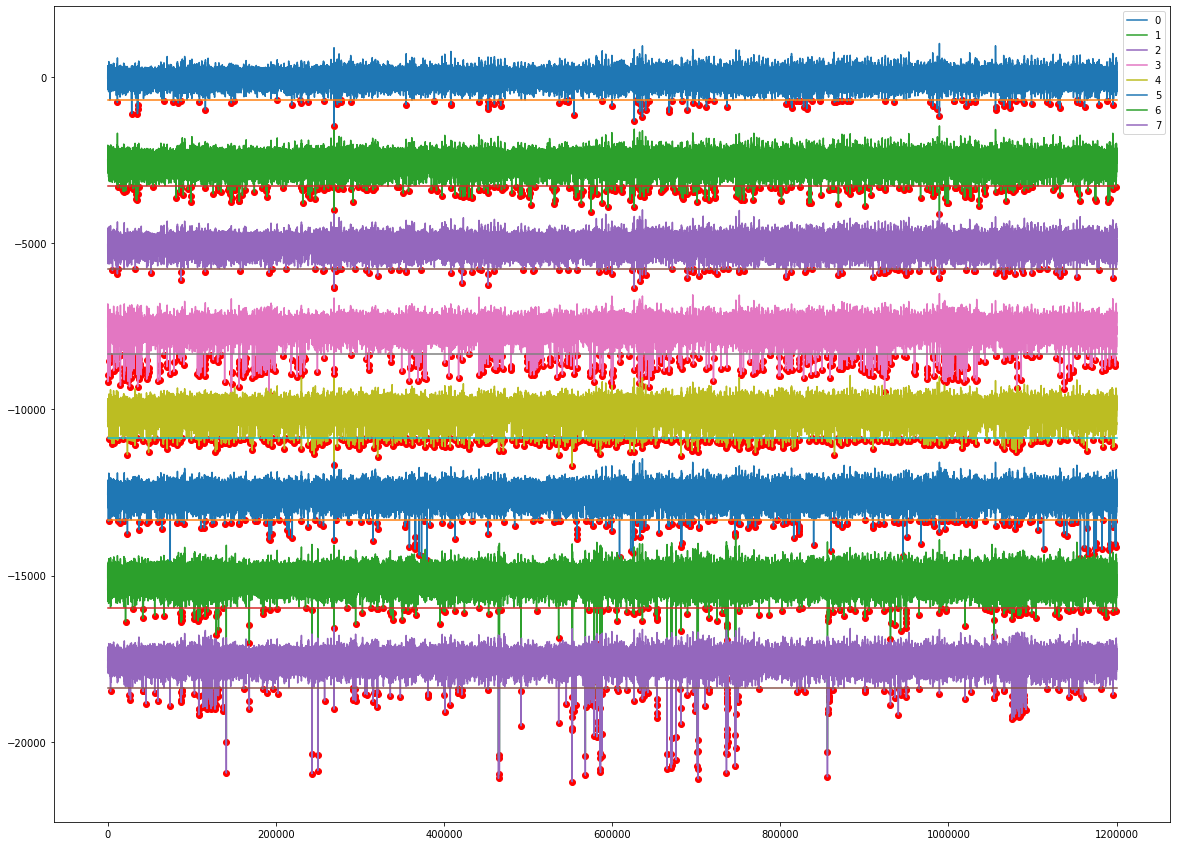

CPU times: user 6.25 s, sys: 1.13 s, total: 7.38 s
Wall time: 6.53 s


In [10]:
%%time
# plot the data and run all the analysis performed so far
z=6
spikeDetection.plot_recording_data(dat,startSample=0,endSample=20000,offset=offset)
y = spikeDetection.filter_raw_data(dat,lowcut = lowcut, fs=fs)  # filter the data
spikeTimesList, thresholds = spikeDetection.spike_detection(y,z=z) # detect the spikes
spikeDetection.plot_spike_detection(y,spikeTimesList,thresholds,offset)

To make our task easy, we will work on the spikes detected on channel 3 and 7. 

Number of spikes:  1134


(0, 100000)

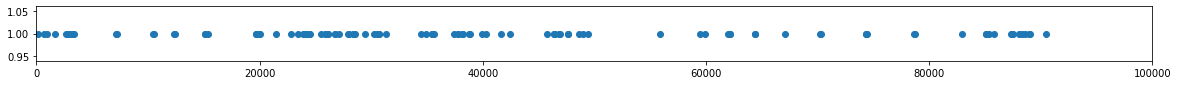

In [11]:
spikeTimes = np.concatenate([spikeTimesList[3],spikeTimesList[5],spikeTimesList[7]])
spikeTimes.sort()
spikeTimes = np.unique(spikeTimes)

print("Number of spikes: ", spikeTimes.shape[0])

# plot 1 second of spikes
plt.figure(figsize=(20,1))
plt.scatter(spikeTimes,np.ones_like(spikeTimes))
plt.xlim(0,100000)

We have detected 23 spikes on channel 3. In this steps, we want to extract the waveforms for these spikes from the filtered signal and store it in a new NumPy array.

<div>
<img src="../images/spike_extraction.png" width="800"/>
</div>

To do this, we need to decide on how many samples we collect per spike. 40 could be a reasonable choice. This is 1 ms before and 1 ms after the spike negative peak. 


* Axis 0: 8 channels
* Axis 1: 40 samples
* Axis 2: 23 spikes



Let's create our 3D array.

In [12]:
samplesPerSpike=40
waveforms=np.empty((dat.shape[0],samplesPerSpike,spikeTimes.shape[0]))
print("Shape of the waveforms array:",waveforms.shape)

Shape of the waveforms array: (8, 40, 1134)


Extract a first spike to test our strategy.

In [13]:
st = spikeTimes[0]
print(st)
start_index=int(st-samplesPerSpike/2)
end_index=int(st+samplesPerSpike/2)
print(start_index,end_index)
print(waveforms[:,:,0].shape)
print(y[:,start_index:end_index].shape)
waveforms[:,:,0] = y[:,start_index:end_index]

98
78 118
(8, 40)
(8, 40)


As always, plot your results to make sure it looks like you expect.

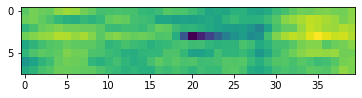

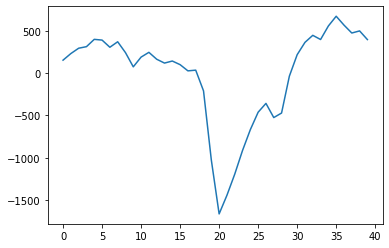

In [14]:
plt.imshow(waveforms[:,:,0])
plt.show()
plt.plot(waveforms[3,:,0])
plt.show()

Extract all 1005 spikes

In [15]:
for i,st in enumerate(spikeTimes):
    start_index=int(st-samplesPerSpike/2)
    end_index=int(st+samplesPerSpike/2)
    waveforms[:,:,i] = y[:,start_index:end_index]

## Visualize your results

As 3D plots are hard to visualize, we will plot a series of 2D plots.

Here are some guidlines to visualize the content of NumPy arrays of different dimensions. 

#### 1D 
* plt.plot(x)
* plt.hist(x)

#### 2D
* plt.plot(x[i,:]
* plt.hist(x[i,:]))
* plt.imshow()

#### 3D
* plt.plot(x[i,j,:])
* plt.imshow(x[i,:,:])

In our case, we will use `plt.imshow()` several times, once per spike.

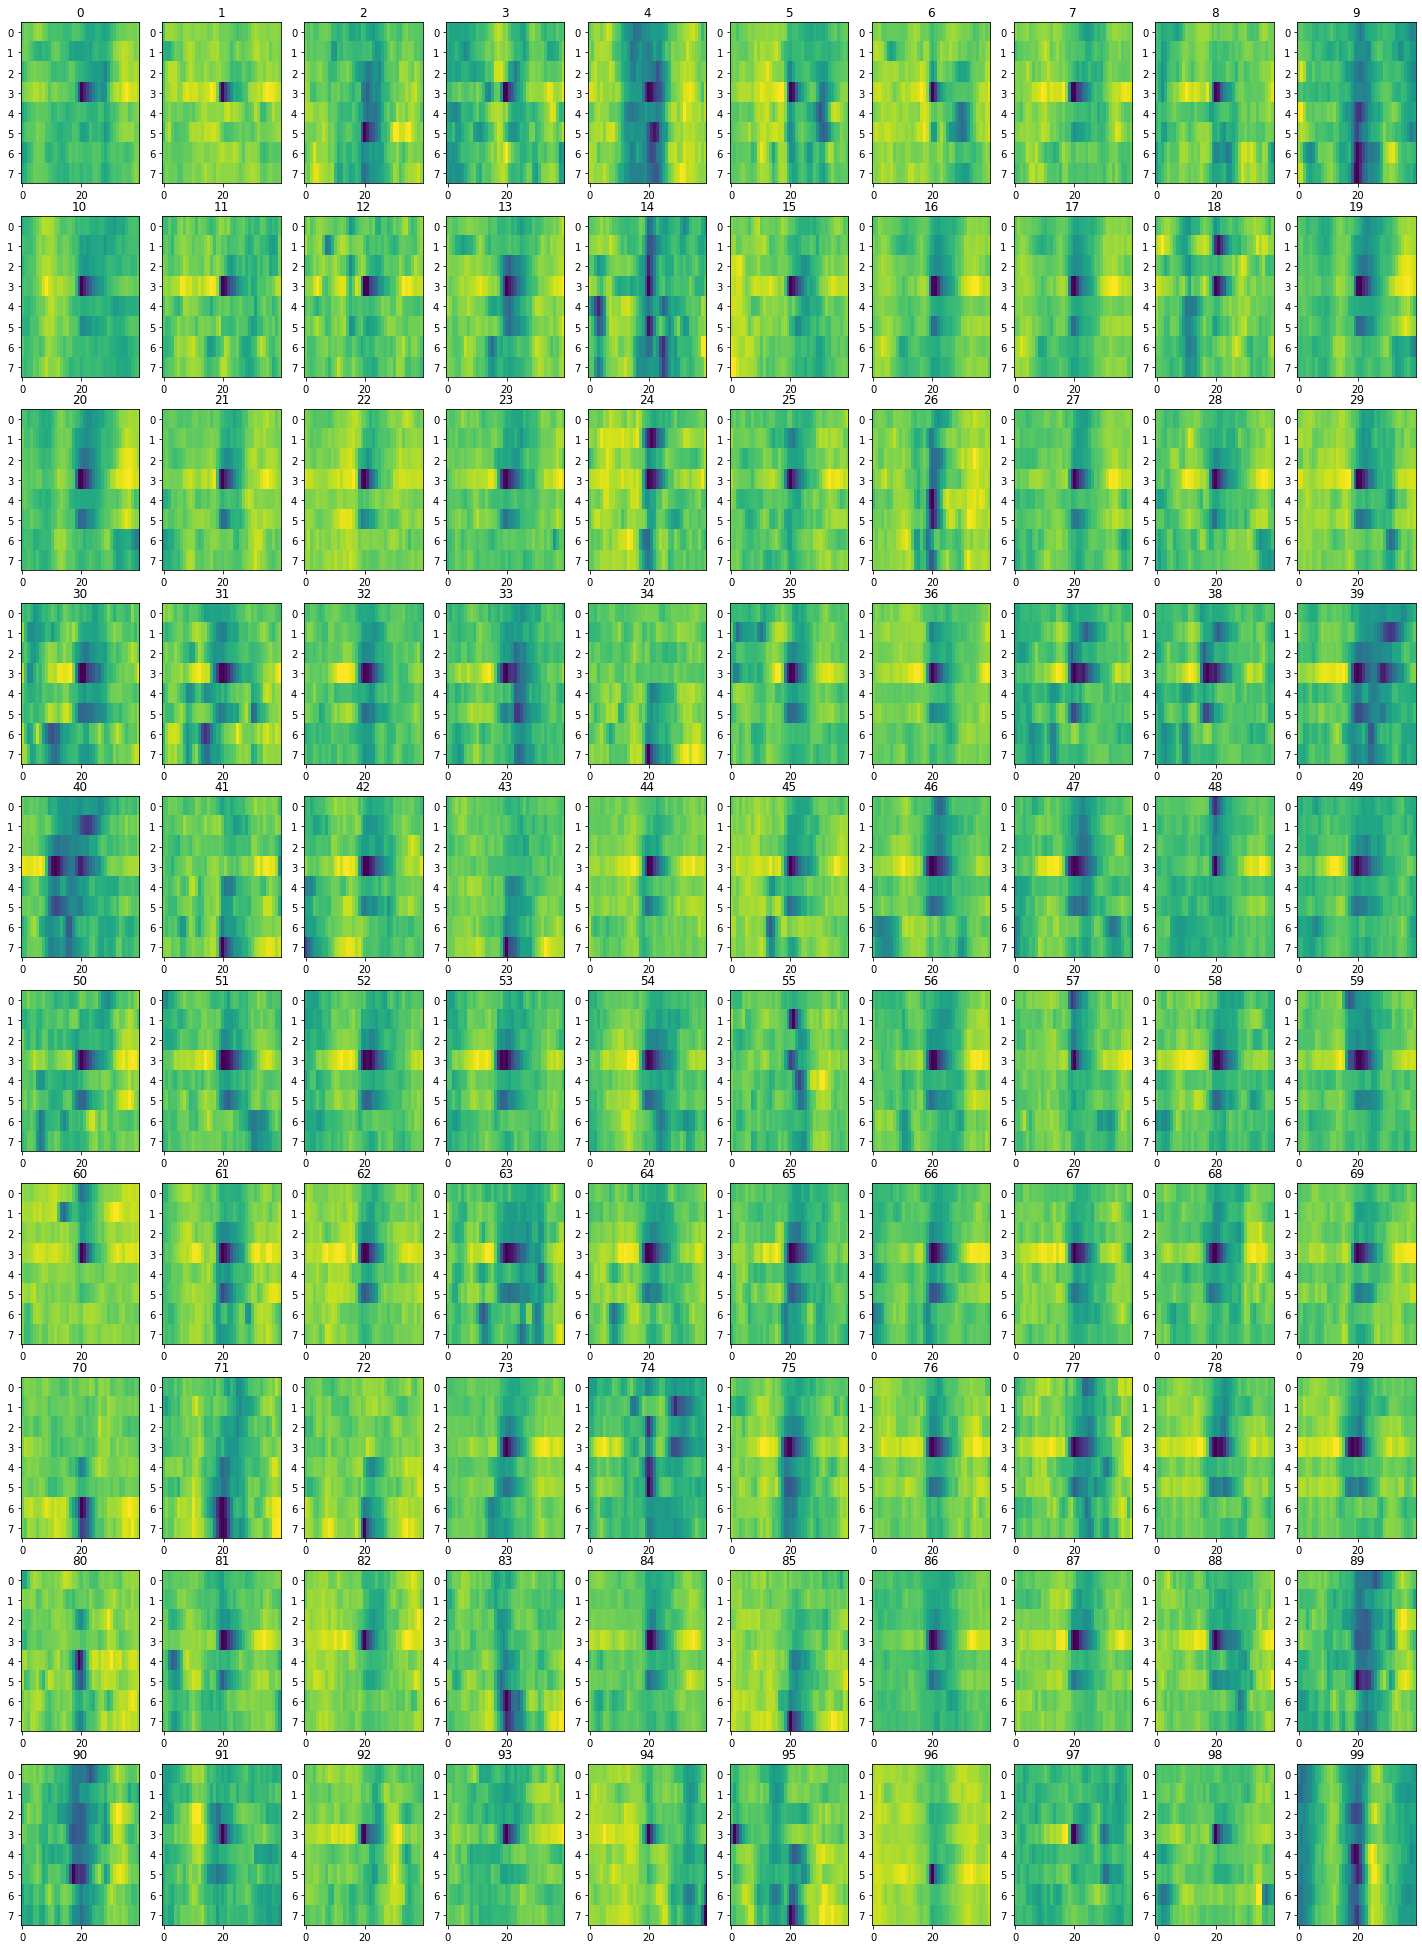

In [16]:
nrow=10
ncol=10
fig, ax = plt.subplots(nrow,ncol,figsize=(25,35))
for i in range(100):
    
    ax[int(i/ncol),i%ncol].imshow(waveforms[:,:,i],aspect="auto",interpolation="none")
    ax[int(i/ncol),i%ncol].set_title(i)

## Discussion

* What do you see in this figure? What is on the x-axis and y-axis of each image?
* Do you notice some patterns in the data?
* Are there spikes that are clearly different from the other ones?
* Do you think there are groups of spikes with similar waveforms?

***
## Dimensionality reduction

Our end goal is to cluster the spikes in groups with very similar spike waveforms (putative neurons). This can be done with different clustering algorithms. 

In the context of clustering, every data point of a 2D waveform is a feature of the waveform.

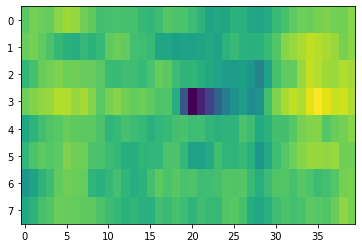

One waveform shape: (8, 40)
Features per spike: 320


In [17]:
plt.imshow(waveforms[:,:,0],aspect="auto",interpolation="none")
plt.show()
oneSpike= waveforms[:,:,0]
print("One waveform shape:",oneSpike.shape)
print("Features per spike:",oneSpike.shape[0]*oneSpike.shape[1])

We have too many features: 320 (8 channels * 40 samples) data points per spikes. If we had more than 100,000 spikes as commonly seen in the lab, the clustering algorithms would be very slow.

### Aim : summarize the data as accurately as possible with fewer features

The traditional way to do this is with **principal component analysis** or **PCA**. 

PS: There are now fancier way to do dimensionality reduction (e.g., autoencoder).

### Principal component analysis

Principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data, sometimes using only the first few principal components and ignoring the rest.

Each component is a linear combination of the features and a set of coefficients. The first component is the vector in which there is the most variance in the data.

* [wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)
* [PCA with scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

We will use a class from the [scikit-learn](https://scikit-learn.org/stable/index.html#) package to do PCA. scikit-learn is a package to apply machine learning

### Simplest example of PCA

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 

Let's generate a very simple data set with 2 features (2D) per data point.

(100, 2)


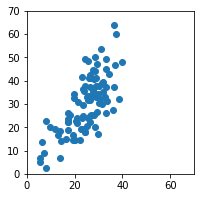

In [19]:
n=100
xx = np.random.normal(loc=25,scale=10,size=n)
yy = xx*1.2+np.random.normal(loc=0,scale=8,size=n)
X = np.vstack([xx,yy]).T
print(X.shape)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0],X[:,1])
plt.xlim(0,70)
plt.ylim(0,70)
plt.show()

In [20]:
pca.fit(X)
print("components:")
print(pca.components_)
print("explanied variance:")
print(pca.explained_variance_)
print("explained variance ratio")
print(pca.explained_variance_ratio_)
print("mean")
print(pca.mean_)

components:
[[-0.4882664  -0.87269463]
 [ 0.87269463 -0.4882664 ]]
explanied variance:
[237.30092452  23.12105546]
explained variance ratio
[0.91121696 0.08878304]
mean
[23.86794097 28.83965863]


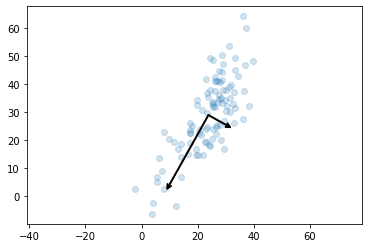

In [21]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

### Reduce the dimensions by taking only the first principal components explaining most of the variance.

In [22]:
pca = PCA(n_components=1) 
Xt = pca.fit_transform(X)
X.shape, Xt.shape

((100, 2), (100, 1))

### Back to our spikes

Each spike is a 320-feature observation. We have 320 dimensions. 

We can use PCA analyssi to reduce the number of features without loosing too much information.

To use PCA, we frst need to format our data for in the typical format for machine learning: a 2D array [observations,features].




<div>
<img src="../images/spike_features_array_transformation.png" width="1000"/>
</div>





**Note**: Most machine learning algorithms work with 2D NumPy arrays [observations,features].

In [23]:
print(waveforms.shape)
# change the order of the dimensions from [channels, samples, spikes] to [spikes, channels,samples]
wf_fea = waveforms.transpose(2,0,1)
print(wf_fea.shape)
X = wf_fea.reshape(wf_fea.shape[0],-1)
print("dimension:",X.shape)

(8, 40, 1134)
(1134, 8, 40)
dimension: (1134, 320)


In [24]:
pca = PCA(n_components=20) 
pca.fit(X)

PCA(n_components=20)

[0.2799666  0.18287984 0.09765517 0.04867563 0.04637084 0.03787935
 0.02369343 0.02291512 0.0166045  0.01504372 0.01271984 0.01062211
 0.01020937 0.00929354 0.00858053 0.00700607 0.00688681 0.00651034
 0.00597005 0.00518432]
Total explained variance:  0.8546671804458594


Text(0, 0.5, 'Explained variance')

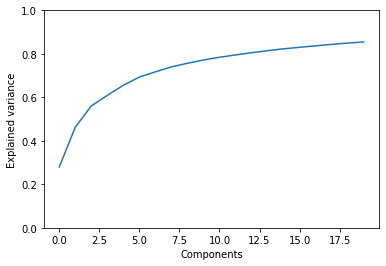

In [25]:
print(pca.explained_variance_ratio_)
print("Total explained variance: ", np.sum(pca.explained_variance_ratio_))
#
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0,1)
plt.xlabel("Components")
plt.ylabel("Explained variance")

In [26]:
Xt = pca.transform(X)
print("old dimensions:",X.shape)
print("new dimensions:",Xt.shape)

old dimensions: (1134, 320)
new dimensions: (1134, 20)


We went from 320 to 15 features per spikes. 

We can print the first 2 PC of the spikes.

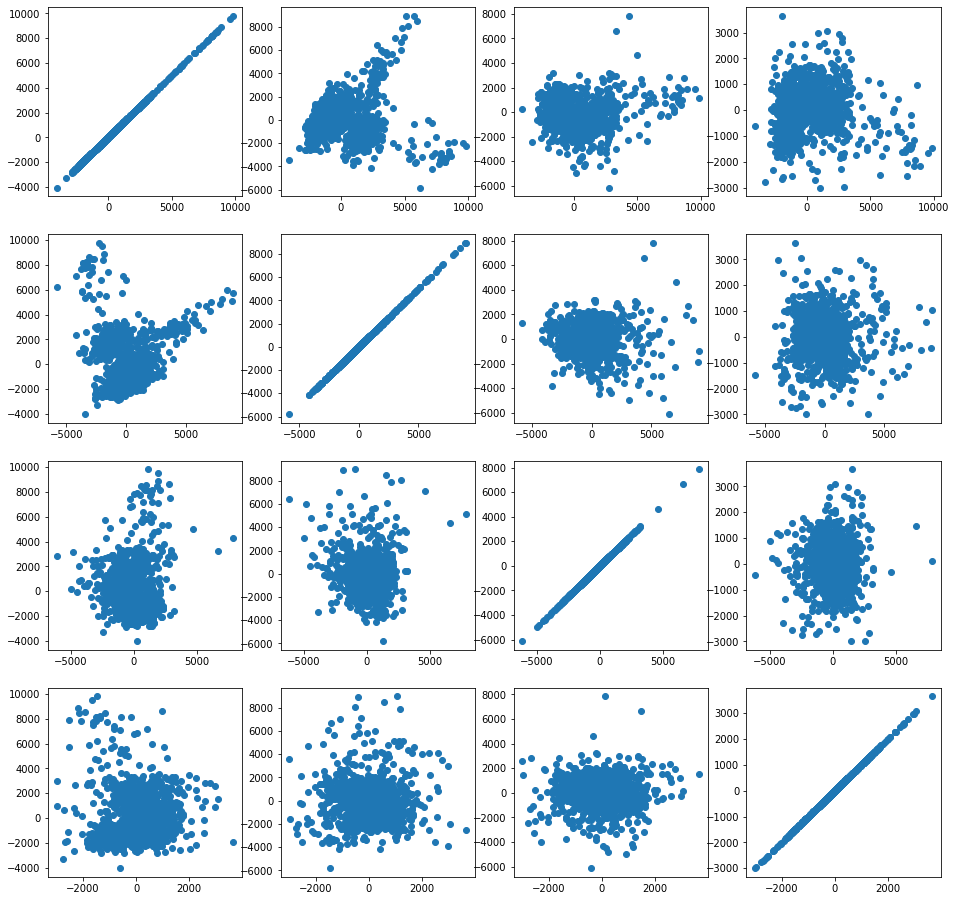

In [27]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
for i in range(4):
    for j in range(4):
        ax[i,j].scatter(Xt[:,i],Xt[:,j])
    
plt.show()

### Discussion

* Do you notice any patterns in the data?
* How many neurons do you think we can find in this data?

***
## Clustering spike waveforms

We would now like to group our spikes according to how similar they are.

This is a [clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering) problem. scikit-learn has many clustering algorithms ready for you to use.

The documentation on the scikit-learn website can help you choose an approriate clustering algorithm. 

### k-means clustering

The k-means algorithm is one of the most commonly used clustering techniques. 

You need ot know how many clusters you expect.

After initialization, K-means consists of looping between the two other steps. 

* Assigns each sample to its nearest centroid. 
* Creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. 

In [28]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(Xt)

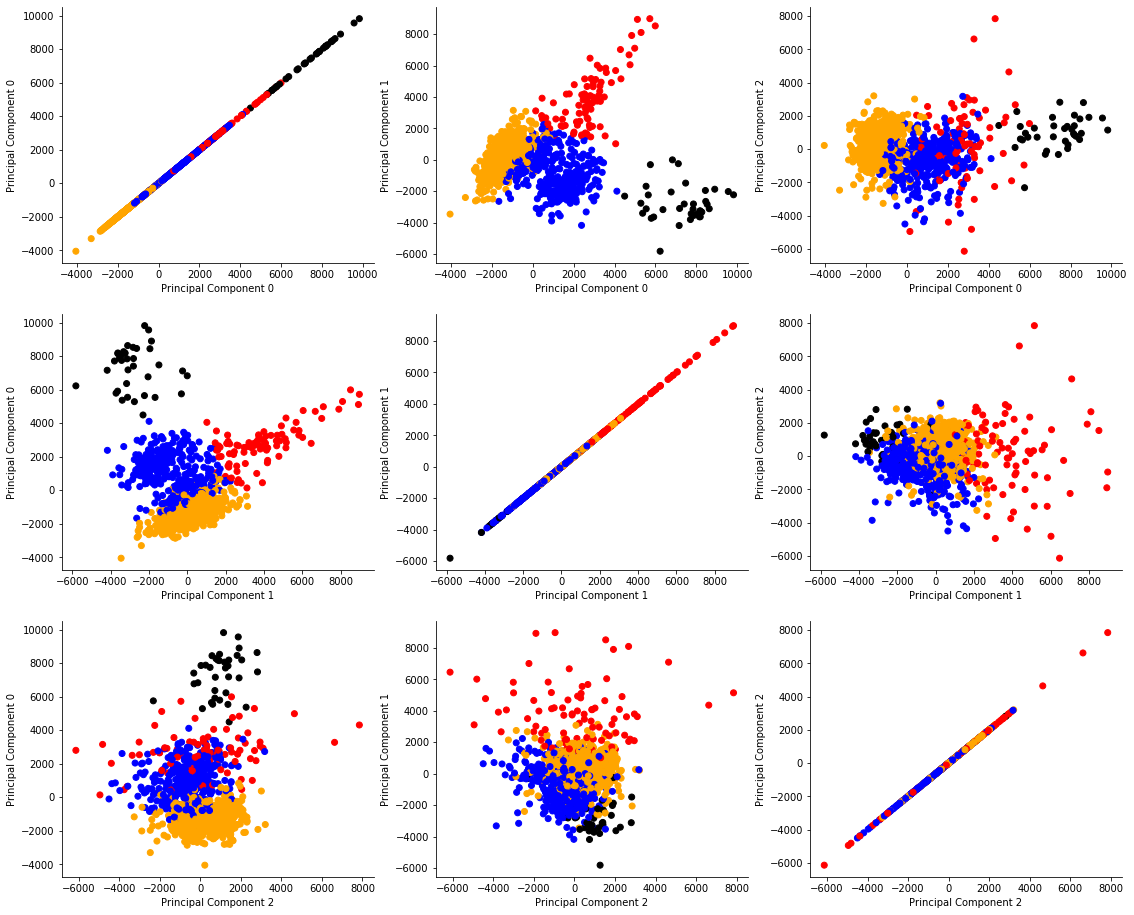

In [44]:
myColorsDict={0:"blue",1:"red",2:"black",3:"orange",4:"purple",5:"green",6:"gray"}
labelColor = [myColorsDict[i] for i in kmeans.labels_]

fig,ax = plt.subplots(3,3,figsize=(19,16))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(Xt[:,i],Xt[:,j],c=labelColor)
        ax[i,j].set_xlabel("Principal Component {}".format(i))
        ax[i,j].set_ylabel("Principal Component {}".format(j))
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
fn="../images/pca.png"
plt.savefig(fn)
plt.show()

### Exercises: Get the mean waveform of each cluster

* Plot the mean waveform of the first cluster (cluster==0).
* Plot the mean waveform of all our clusters.
* Is there a cluster that look very different from the other? What could this represent?


### Reconstruct with the waveforms array and kmeans.labels_

In [31]:
clusterIndices = kmeans.labels_==0
print(np.sum(clusterIndices))
print(clusterIndices.shape)
print(waveforms.shape)


375
(1134,)
(8, 40, 1134)


(8, 40, 1134)
(8, 40, 375)


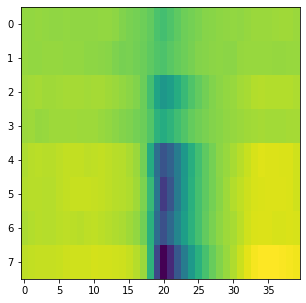

In [32]:
# plot mean waveforms one cluster
clu = 0
clusterIndices = kmeans.labels_==clu
clusterIndices.shape,clusterIndices.sum()
print(waveforms.shape)
selWaveforms = waveforms[:,:,clusterIndices]
print(selWaveforms.shape)
plt.figure(figsize=(5,5))
plt.imshow(selWaveforms.mean(axis=2),aspect="auto")
plt.show()

CPU times: user 97.9 ms, sys: 237 µs, total: 98.1 ms
Wall time: 95.3 ms


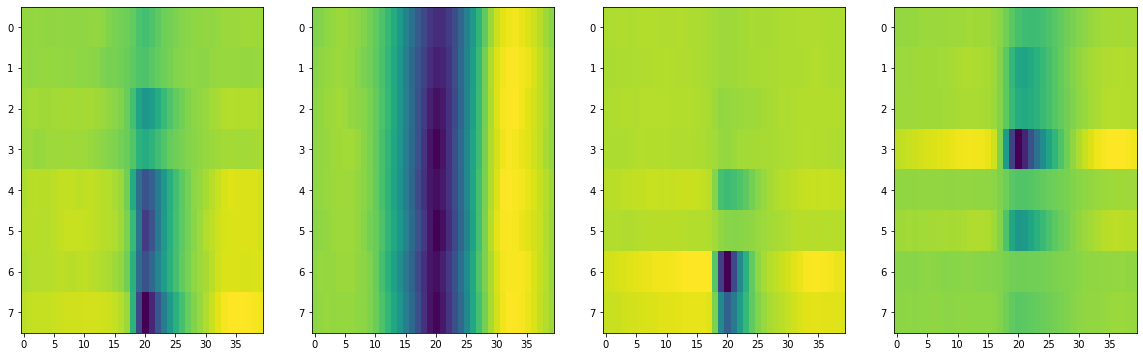

In [33]:
%%time
# plot mean waveforms all clusters
# get the cluID of kmeans object, then retrieve the waveforms from the waveforms array

nClu = np.unique(kmeans.labels_).shape[0]

fig, ax = plt.subplots(1,nClu,figsize=(20,6))

for i, clu in enumerate(np.unique(kmeans.labels_)):
    clusterIndices = kmeans.labels_==clu
    w = waveforms[:,:,clusterIndices].mean(axis=2)
    ax[i].imshow(w,aspect="auto")

### Reconstruct waveforms from the 15 featues of the PCA

We now use 15 numbers per waveforms to reconstruct the 320 data points of the waveform. Impressive stuff!

The pca object has an inverse_transform method.

In [34]:
%%time
recoWaveforms = pca.inverse_transform(Xt)
print(recoWaveforms.shape)

(1134, 320)
CPU times: user 22.2 ms, sys: 3.2 ms, total: 25.4 ms
Wall time: 4.02 ms


(1134, 8, 40)
(8, 40, 1134)


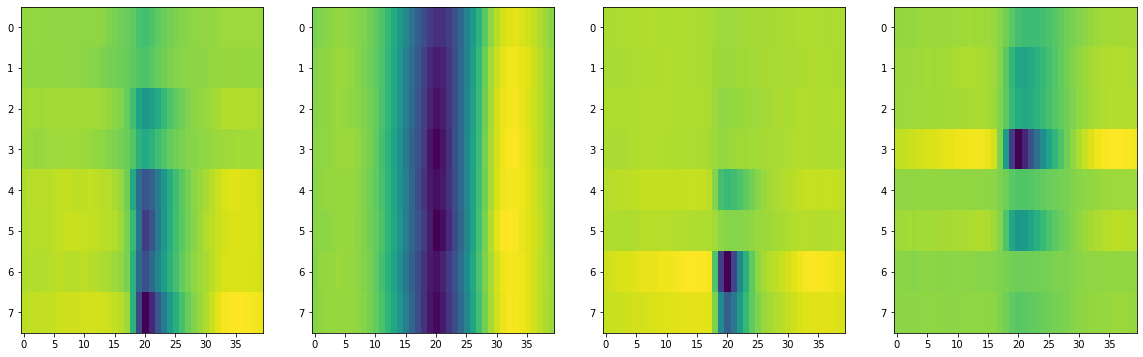

In [35]:
W = recoWaveforms.reshape(recoWaveforms.shape[0],8,-1)
print(W.shape)
W = W.transpose(1,2,0)
print(W.shape)

nClu = np.unique(kmeans.labels_).shape[0]
fig, ax = plt.subplots(1,nClu,figsize=(20,6))

for i, clu in enumerate(np.unique(kmeans.labels_)):
    clusterIndices = kmeans.labels_==clu
    w = W[:,:,clusterIndices].mean(axis=2)
    ax[i].imshow(w,aspect="auto")

### The fastest way (will not take longer when you have more spikes): 

* Get means of clusters from kmeans (already calculated from clustering)
* Inverse transform the mean features of each cluster (apply only to numberOfClustersxnumberOfFeatures numbers)
* Plot

(4, 20)
CPU times: user 33.7 ms, sys: 3.67 ms, total: 37.3 ms
Wall time: 36 ms


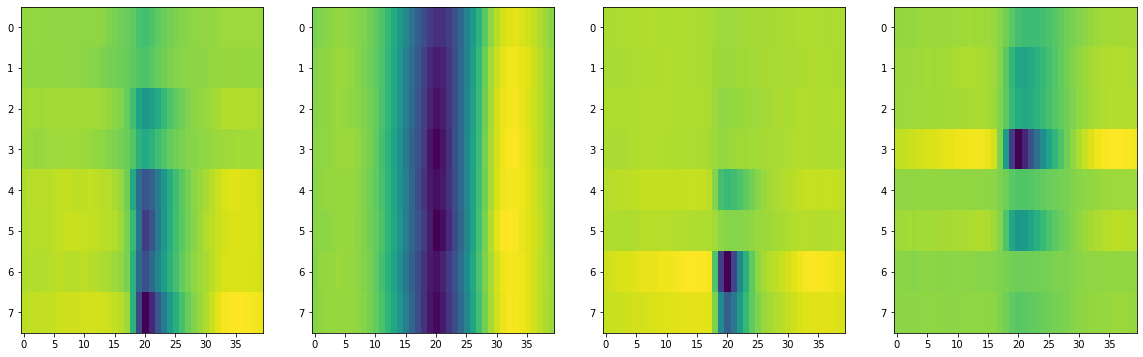

In [36]:
%%time

means = kmeans.cluster_centers_ # get the means of the clusters (already calculated by kmeans)
print(means.shape)
meanWaveforms = pca.inverse_transform(means) # transform 4 waveforms instead of 1000

fig, ax = plt.subplots(1,nClu,figsize=(20,6))
for i in range(meanWaveforms.shape[0]):
    ax[i].imshow(meanWaveforms[i,:].reshape(8,-1),aspect="auto") # no mean calculation needed!